Visualizing the Healthscores across California Counties

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import shapely
import shapefile
import plotly 
import plotly.plotly as py


In [2]:
#checking for the right versions of the packages
print(gpd.__version__ , shapely.__version__, plotly.__version__)

0.3.0 1.6.3 2.7.0


In [3]:
plotly.tools.set_credentials_file(username = 'jmk054', api_key = '7df6SuCIVByxcSAe3TYv')

In [4]:
#importing the data
d = pd.read_csv('hpi.csv')

In [5]:
#looking at the data
d.head()

,geoid,pop2010,pct2010gq,city,zip,county_fips,county_name,urbantype,hpi2score,hpi2_pctile_pos,...,leb_pctile,white_pct,black_pct,asian_pct,latino_pct,multiple_pct,nativeam_pct,pacificisl_pct,other_pct,version
0,14000US06001400100,2937,0.1,Oakland,94704.0,6001,Alameda,urban_area,1.182028,99.114590,...,96.663673,71.605789,4.824259,15.713301,4.031702,3.824948,0.0,0.0,0,Wed13Dec17
1,14000US06001400200,1974,3.5,Oakland,94618.0,6001,Alameda,urban_area,1.325874,99.704863,...,96.612344,83.884970,0.000000,7.921867,8.193163,0.000000,0.0,0.0,0,Wed13Dec17
2,14000US06001400300,4865,0.8,Oakland,94618.0,6001,Alameda,urban_area,0.925666,95.932247,...,95.136661,67.384106,10.596026,8.671358,8.257450,5.091060,0.0,0.0,0,Wed13Dec17
3,14000US06001400400,3703,0.9,Oakland,94609.0,6001,Alameda,urban_area,1.117603,98.537149,...,68.959322,66.031054,12.203759,7.354944,9.043857,5.366385,0.0,0.0,0,Wed13Dec17
4,14000US06001400500,3517,3.6,Oakland,94609.0,6001,Alameda,urban_area,0.562799,83.318363,...,38.855383,51.180196,26.856649,5.987334,9.786989,6.188831,0.0,0.0,0,Wed13Dec17


In [6]:
#this d.info was run to look at the data
#d.info()

To get rid of the version, percentiles, and otehr columns which aren't needed in PCA

In [7]:
pcnt = [label for label in list(d) if "pcti" in label]
pcnt[:5]

['hpi2_pctile_pos',
 'hpi2_pctile_neg',
 'economic_pctile',
 'education_pctile',
 'houseing_pctile']

In [8]:
#drop from the dataframe
to_drop = ["geoid","version", "quintiles", "quartiles", "hpi_top25pct"] + pcnt 
df = d.drop(to_drop, axis = 1)

Looking at the info data below, we can see there are 8057 different entires, but only 7793 non-null entries in most columns. The city column has the LEAST non-null objects at 6972. 

The number of rows where any of the values are Nan. Since we dropped all the values with Nan.

create a dataframe with only notnull values

In [9]:
print("The number of rows with NaNs in them are: %d" % len(df[df.isnull().any(axis = 1)]))
df = df[df.notnull().all(axis = 1)]

The number of rows with NaNs in them are: 1242


In [10]:
len(df)

6815

In [11]:
len(df.groupby("county_name"))

54

In [12]:
#processing the categorical data by the county and take the "mode"
categorical = df.groupby(["county_name"]).agg(lambda x: x.value_counts().index[0])[["city", "urbantype"]].reset_index()
categorical.head()

,county_name,city,urbantype
0,Alameda,Oakland,urban_area
1,Amador,Pine Grove,rural
2,Butte,Chico,urban_area
3,Calaveras,Avery,rural
4,Colusa,College City,urban_cluster


The number of counties after cleaning

In [13]:
len(categorical)

54

In [14]:
group = df.groupby("county_name").mean().reset_index()
group["urbantype"] = categorical["urbantype"]
group["biggest city"] = categorical["city"]

In [15]:
group.head()

,county_name,pop2010,pct2010gq,zip,county_fips,hpi2score,economic,education,housing,healthcareaccess,...,white_pct,black_pct,asian_pct,latino_pct,multiple_pct,nativeam_pct,pacificisl_pct,other_pct,urbantype,biggest city
0,Alameda,4196.623529,1.879706,94588.085294,6001.0,0.341045,0.396776,0.293851,0.153843,0.553262,...,35.234458,13.723530,25.001636,22.179543,3.574085,0.000000,0.286748,0.0,urban_area,Oakland
1,Amador,4906.500000,2.300000,95652.500000,6005.0,0.150982,-0.347074,0.381420,0.151026,0.737064,...,86.096379,0.000000,0.000000,10.879978,3.023642,0.000000,0.000000,0.0,rural,Pine Grove
2,Butte,4262.212121,2.496970,95951.333333,6007.0,-0.175309,-0.640709,-0.186557,0.212270,0.198127,...,79.071955,0.950791,3.537372,12.415550,3.243284,0.781048,0.000000,0.0,urban_area,Chico
3,Calaveras,3375.000000,0.366667,95222.666667,6009.0,-0.053647,-0.229292,-0.885324,0.387684,0.392219,...,91.629281,0.000000,0.000000,8.370719,0.000000,0.000000,0.000000,0.0,rural,Avery
4,Colusa,5183.000000,0.000000,95912.000000,6011.0,-0.091837,-0.232988,-0.434281,0.368422,-0.635444,...,37.311634,0.000000,0.000000,62.688366,0.000000,0.000000,0.000000,0.0,urban_cluster,College City


The code below is used to calculate the correlation between variables

In [16]:
corr = df.corr()
corr.head()

,pop2010,pct2010gq,zip,county_fips,hpi2score,economic,education,housing,healthcareaccess,neighborhood,...,h20contam,leb,white_pct,black_pct,asian_pct,latino_pct,multiple_pct,nativeam_pct,pacificisl_pct,other_pct
pop2010,1.000000,-0.024989,0.076358,0.106648,-0.022811,-0.003717,-0.083637,0.049737,-0.004300,-0.058104,...,0.061688,-0.011571,-0.106977,-0.010764,0.034885,0.074218,0.221328,0.013089,0.054865,0.071273
pct2010gq,-0.024989,1.000000,0.034928,0.014807,-0.075776,-0.143775,0.004363,-0.108365,0.017437,0.058237,...,-0.053759,-0.108021,0.027731,0.051001,-0.005454,-0.046910,0.043279,0.011767,-0.013597,0.056818
zip,0.076358,0.034928,1.000000,0.276312,0.202374,0.107918,0.025094,0.291597,0.326976,0.270995,...,-0.276441,-0.092273,0.280706,-0.095534,0.098261,-0.331268,0.379323,0.090653,0.067788,0.003145
county_fips,0.106648,0.014807,0.276312,1.000000,0.063009,0.050620,-0.034159,0.121079,0.099378,0.080661,...,0.046785,-0.028519,0.167483,-0.201274,-0.043774,-0.071025,0.065210,-0.012503,-0.013348,0.015386
hpi2score,-0.022811,-0.075776,0.202374,0.063009,1.000000,0.951434,0.767557,0.710175,0.804472,0.356768,...,-0.299141,0.561417,0.639976,-0.281724,0.275268,-0.719144,0.392291,-0.044604,-0.038971,0.001132


In [17]:
corr["hpi2score"][:10]

pop2010            -0.022811
pct2010gq          -0.075776
zip                 0.202374
county_fips         0.063009
hpi2score           1.000000
economic            0.951434
education           0.767557
housing             0.710175
healthcareaccess    0.804472
neighborhood        0.356768
Name: hpi2score, dtype: float64

In [18]:
cities = list(df["city"].unique())
counties = list(df["county_name"].unique())

In [19]:
len(cities), len(counties)

(717, 54)

In [20]:
scores2 = []
cities2 = []
for city in cities:
    small_df = df[df["city"] == city]
    #if len(small_df) >1:
    scores2.append(np.average(small_df["hpi2score"]))
    cities2.append(city)
    

PCA

In [21]:
pc_df = df.drop(["city", "zip", "county_fips", "urbantype", "county_name", "hpi2score"], axis = 1)
pc_df.head()

,pop2010,pct2010gq,economic,education,housing,healthcareaccess,neighborhood,pollution,transportation,social,...,h20contam,leb,white_pct,black_pct,asian_pct,latino_pct,multiple_pct,nativeam_pct,pacificisl_pct,other_pct
0,2937,0.1,1.735963,0.948968,0.730552,1.285242,0.832170,0.878125,0.616855,1.336602,...,70.599583,86.985506,71.605789,4.824259,15.713301,4.031702,3.824948,0.0,0.0,0
1,1974,3.5,1.808761,1.137725,0.959728,1.004971,0.503232,0.657261,1.494366,1.227116,...,70.599583,86.957616,83.884970,0.000000,7.921867,8.193163,0.000000,0.0,0.0,0
2,4865,0.8,1.014492,1.348314,0.603628,1.268756,-0.291977,0.657261,0.822268,1.078500,...,70.599583,86.462942,67.384106,10.596026,8.671358,8.257450,5.091060,0.0,0.0,0
3,3703,0.9,1.277657,0.939501,0.356477,1.301729,0.070027,0.657261,1.756657,1.295417,...,70.599583,82.710897,66.031054,12.203759,7.354944,9.043857,5.366385,0.0,0.0,0
4,3517,3.6,0.577803,0.486145,0.029926,0.485643,-0.106063,0.657261,0.873072,0.949500,...,70.599583,80.123238,51.180196,26.856649,5.987334,9.786989,6.188831,0.0,0.0,0


In [22]:
from sklearn.decomposition import PCA
pca = PCA(n_components =2)
pca.fit(pc_df)
pca.components_[0]

array([ 8.05713540e-04, -1.04183868e-05,  2.35237513e-05,  1.26217914e-05,
        1.36428076e-05,  2.18745199e-05,  2.95671506e-06,  5.59447884e-06,
        4.65870223e-06,  1.75948560e-05,  2.65361526e-04,  1.65054173e-04,
        4.57362882e-04,  1.25206264e-04, -6.07536148e-05,  2.94012512e-04,
        1.86208078e-05,  4.81921138e-04,  1.24060663e-04,  5.18137238e-04,
        9.99997883e-01, -1.27232702e-05,  9.75860982e-05,  6.65843991e-05,
        4.48498222e-04,  2.00682758e-04, -9.60329524e-05, -1.67589945e-04,
        1.46863456e-05,  2.16483888e-04, -2.75230414e-04, -7.45938145e-08,
       -1.26259285e-05, -8.14068991e-05, -1.33438106e-03,  5.55103326e-05,
        4.33819173e-04, -8.15177386e-05,  1.19741011e-04, -4.87844779e-04,
        1.71640848e-05, -7.26258770e-07, -6.33826950e-07,  2.28888866e-10])

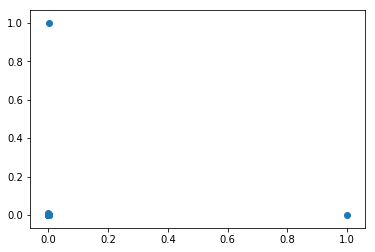

In [23]:
plt.scatter(pca.components_[0], pca.components_[1])

# Choropleth map

In [24]:
len(df.groupby("county_name"))

54

In [25]:
county = group["county_fips"]
score = group["hpi2score"]

In [26]:
#using figure factory for a single state
import plotly.figure_factory as ff

https://towardsdatascience.com/an-introduction-to-geographical-data-visualization-3486959cd4b8

Looking at the range of values for the HpiScore, some are actually negative, so have to take that into account

In [27]:
min(group["hpi2score"]),max(group["hpi2score"])

(-0.6454781168461541, 0.7790843871276596)

In [28]:
val = .779
(val+1)*10

17.79

In [29]:
colors_to_plot = []
for county in group["county_name"]:
    score = group[group["county_name"] == county]["hpi2score"]
    normalized_score = int((score)*10)
    colors_to_plot.append(normalized_score)
    #group["nom_scores"].loc[county] = score
    

In [30]:
group["norm_score"] = colors_to_plot

# BOKEH plotting

In [31]:
import bokeh

In [32]:
from bokeh.sampledata.us_counties import data as counties
from bokeh.sampledata.us_states import data as states
from bokeh.sampledata.unemployment import data as unemployment

In [33]:
#get the lat and long of the state of CA (since just a heatmap of Cali)
state_lon = states["CA"]["lons"]
state_lat = states["CA"]["lats"]
#state_x

In [34]:
#make 3 lists, each with the name, lat and lon of all counties in California
name = []
lat = []
lons = []
names = [(name.append(counties[code]["detailed name"]), lat.append(counties[code]["lats"]), lons.append(counties[code]["lons"])) for code in counties if counties[code]["state"] in ["ca"]]
#latlon = [counties[code]["detailed name"] for code in counties if counties[code]["state"] in ["ca"]]

In [35]:
#put these lists into a dataframe for easier access
locations = pd.DataFrame()
locations["names"] = name
locations["lats"] = lat
locations["lons"] = lons

In [36]:
#example output of new df
locations.head()

,names,lats,lons
0,"Alameda County, California","[37.90194, 37.89909, 37.8965, 37.8941, 37.8870...","[-122.26254, -122.25876, -122.25586, -122.2530..."
1,"Alpine County, California","[38.88801, 38.88374, 38.87596, 38.86882, 38.85...","[-119.83828, -119.832, -119.82106, -119.81054,..."
2,"Amador County, California","[38.53596, 38.50946, 38.50418, 38.51042, 38.51...","[-120.70401, -120.64529, -120.59707, -120.5583..."
3,"Butte County, California","[39.52657, 39.52658, 39.51325, 39.46875, 39.45...","[-121.23727, -121.23866, -121.3052, -121.33296..."
4,"Calaveras County, California","[38.40885, 38.40873, 38.39886, 38.37713, 38.35...","[-120.0819, -120.08198, -120.12248, -120.16929..."


In [37]:
#get rid of "County, California" in each of the "names" so can join wtih hpi score column/df 
locations["county_names"] = locations["names"].apply(lambda x: x[:-19])

In [38]:
#new df check
locations.head(2)

,names,lats,lons,county_names
0,"Alameda County, California","[37.90194, 37.89909, 37.8965, 37.8941, 37.8870...","[-122.26254, -122.25876, -122.25586, -122.2530...",Alameda
1,"Alpine County, California","[38.88801, 38.88374, 38.87596, 38.86882, 38.85...","[-119.83828, -119.832, -119.82106, -119.81054,...",Alpine


In [39]:
scores_df = pd.DataFrame()
scores_df["county_names"] = group["county_name"]
scores_df["hpiscore"] = group["hpi2score"]
scores_df["norm_score"]= group["norm_score"]


In [40]:
scores_df.head(1)

,county_names,hpiscore,norm_score
0,Alameda,0.341045,3


In [41]:
full_df = pd.merge(scores_df, locations, how = "outer", on=["county_names"])
full_df.head(1)


,county_names,hpiscore,norm_score,names,lats,lons
0,Alameda,0.341045,3.0,"Alameda County, California","[37.90194, 37.89909, 37.8965, 37.8941, 37.8870...","[-122.26254, -122.25876, -122.25586, -122.2530..."


In [42]:
full_df = full_df.fillna("0")

In [43]:
#http://bokeh.pydata.org/en/latest/docs/gallery/texas.html
#used the documentation above as a template to make my figure
from bokeh.io import output_notebook
from bokeh.models import LogColorMapper
#palette is a list of hexs
from bokeh.palettes import RdBu8 as palette
from bokeh.plotting import figure, show

In [44]:
#issue with lat and long JSON encoding (need to turn into arrays)
#https://github.com/bokeh/bokeh/issues/6222
    

In [45]:
palette.reverse()
#this makes the dark blue correlate with a higher health score and white with lower score

maps=dict(
    x=[np.asarray(i) for i in full_df["lons"]],
    y=[np.asarray(i) for i in full_df["lats"]],
    name=np.array(full_df["county_names"]),
    scores= np.array(full_df["hpiscore"]),
)

#colors
color_mapper = LogColorMapper(palette=palette)

p = figure(
    title="Hpi2score by California county", 
    #gets rid of axis on right/left (doesn't matter much for this graph)
    x_axis_location=None, 
    y_axis_location=None,
    
    #https://bokeh.pydata.org/en/latest/docs/user_guide/tools.html
    #all the different tools that can be added 
    tools="reset,hover,pan,box_zoom",
    #a key for the tools
    tooltips=[
        ("County name", "@name"), ("Hpi Scores", "@scores"), ("(Longitude, Latitude)", "($x, $y)")
    ])
p.grid.grid_line_color = None
p.hover.point_policy = "follow_mouse"

p.patches('x', 'y', source=maps,
          fill_color={'field': 'scores', 'transform': color_mapper},
          fill_alpha=1, line_color="white", line_width=1)

output_notebook()
show(p)

Loading BokehJS ...

# Plotting Diversity:

In [46]:
list(group)

['county_name',
 'pop2010',
 'pct2010gq',
 'zip',
 'county_fips',
 'hpi2score',
 'economic',
 'education',
 'housing',
 'healthcareaccess',
 'neighborhood',
 'pollution',
 'transportation',
 'social',
 'insured',
 'uncrowded',
 'homeownership',
 'automobile',
 'commute',
 'inpreschool',
 'inhighschool',
 'bachelorsed',
 'employed',
 'abovepoverty',
 'income',
 'retail',
 'parkaccess',
 'treecanopy',
 'alcoffsale',
 'voting',
 'ownsevere',
 'rentsevere',
 'houserepair',
 'twoparents',
 'supermkts',
 'ozone',
 'pm25',
 'dieselpm',
 'h20contam',
 'leb',
 'white_pct',
 'black_pct',
 'asian_pct',
 'latino_pct',
 'multiple_pct',
 'nativeam_pct',
 'pacificisl_pct',
 'other_pct',
 'urbantype',
 'biggest city',
 'norm_score']

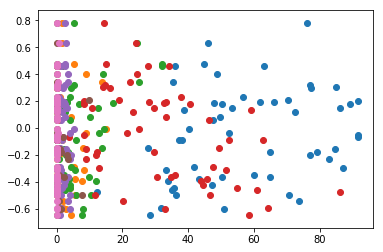

In [47]:
plt.scatter(group["white_pct"], group["hpi2score"])
plt.scatter(group["black_pct"], group["hpi2score"])
plt.scatter(group["asian_pct"], group["hpi2score"])
plt.scatter(group["latino_pct"], group["hpi2score"])
plt.scatter(group["multiple_pct"], group["hpi2score"])
plt.scatter(group["nativeam_pct"], group["hpi2score"])
plt.scatter(group["pacificisl_pct"], group["hpi2score"])
